In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from tensorflow.keras.applications import VGG19
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.vgg19 import preprocess_input

from nst.nst import NSTModel, init_result
from nst.nst import calc_content_loss, calc_style_loss, calc_total_loss
from nst.nst import normalize_image, generate_nst
#from nst.nst import calculate_gradients

%load_ext autoreload
%autoreload

In [2]:
vgg19 = VGG19(include_top=False)
vgg19.trainable=False
vgg19.input_shape

(None, None, None, 3)

In [3]:
vgg19.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0     

(224, 224, 3)
(224, 224, 3)


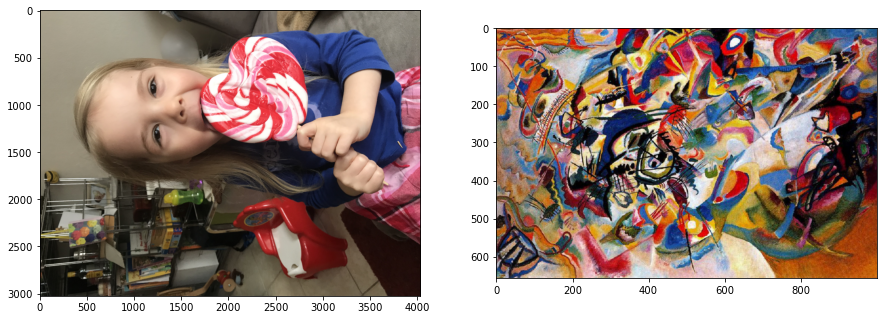

In [10]:
content_image_path = 'images/content_carina_2.jpg'
content = mpimg.imread(content_image_path)
style_image_path = 'images/style_kandinsky_7.jpg'
style = mpimg.imread(style_image_path)

fig, axes = plt.subplots(1, 2, figsize=(15, 10))
axes[0].imshow(content)
axes[1].imshow(style)

input_shape = (224, 224, 3)
content_as_pil = load_img(content_image_path, target_size=input_shape[:-1])
content_as_np = img_to_array(content_as_pil)
style_as_pil = load_img(style_image_path, target_size=input_shape[:-1])
style_as_np = img_to_array(style_as_pil)
print(content_as_np.shape)
print(style_as_np.shape)

In [12]:
content.shape

(3024, 4032, 3)

In [92]:
my_model = NSTModel(vgg19, 
                    content_layers=['block4_conv2'], 
                    style_layers=['block2_conv1', 'block3_conv1', 'block4_conv1', 'block5_conv1'])


content = tf.Variable(normalize_image(content_as_np[np.newaxis,...]), dtype=tf.float32)
style = tf.Variable(normalize_image(style_as_np[np.newaxis,...]), dtype=tf.float32)

#my_model.process(content)
#my_model.process(style)

In [93]:
generator_parameters = {
    'epochs': 1000, 
    'model': my_model, 
    'content': content,
    'style': style,
    'lr': 0.1, 
    'start_from_content': True
}

trained_image, losses = generate_nst(**generator_parameters)

Step: 0
Step: 10
Step: 20
Step: 30
Step: 40
Step: 50
Step: 60
Step: 70
Step: 80
Step: 90
Step: 100
Step: 110
Step: 120
Step: 130
Step: 140
Step: 150
Step: 160
Step: 170
Step: 180
Step: 190
Step: 200
Step: 210
Step: 220
Step: 230
Step: 240
Step: 250
Step: 260
Step: 270
Step: 280
Step: 290
Step: 300
Step: 310
Step: 320
Step: 330
Step: 340
Step: 350
Step: 360
Step: 370
Step: 380
Step: 390
Step: 400
Step: 410
Step: 420
Step: 430
Step: 440
Step: 450
Step: 460
Step: 470
Step: 480
Step: 490
Step: 500
Step: 510
Step: 520
Step: 530
Step: 540
Step: 550
Step: 560
Step: 570
Step: 580
Step: 590
Step: 600
Step: 610
Step: 620
Step: 630
Step: 640
Step: 650
Step: 660
Step: 670
Step: 680
Step: 690
Step: 700
Step: 710
Step: 720
Step: 730
Step: 740
Step: 750
Step: 760
Step: 770
Step: 780
Step: 790
Step: 800
Step: 810
Step: 820
Step: 830
Step: 840
Step: 850
Step: 860
Step: 870
Step: 880
Step: 890
Step: 900
Step: 910
Step: 920
Step: 930
Step: 940
Step: 950
Step: 960
Step: 970
Step: 980
Step: 990


<tf.Tensor: shape=(), dtype=float32, numpy=716.3621>

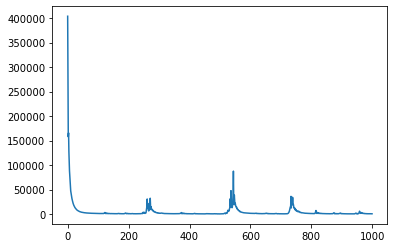

In [94]:
plt.plot(losses)
losses[-1]

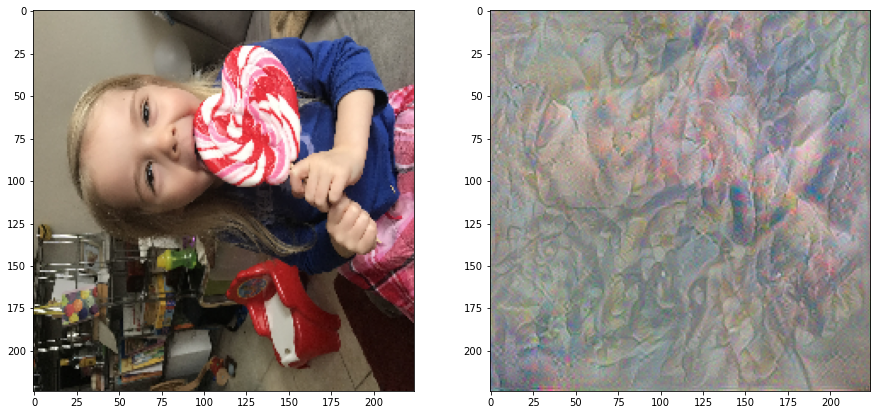

In [95]:
fig, axes = plt.subplots(1, 2, figsize=(15,10))
axes[0].imshow(normalize_image(content_as_np))
axes[1].imshow(trained_image)